In [1]:
#jk

import os
import glob
from tqdm.notebook import tqdm_notebook
import logging as lg
import pickle

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,roc_curve,roc_auc_score,classification_report

from paramsfile import AllModelParams

sns.set(rc={'figure.figsize':(20,7)})

import warnings
warnings.filterwarnings('ignore')

#Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

class PeopleActivityRecognition:
    
    def __init__(self, dir_path, model_best_params):
        self.dir_path = dir_path
        self.model_best_params = model_best_params
        self.evaluation_results_list = []
   
    def create_logger(self):
        try:
            lg.basicConfig(filename='people_activity_recog_classification_logger.log', level = lg.INFO ,format='%(asctime)s - %(levelname)s - %(message)s')
        except Exception as e:
            print(e)
            
    def create_sub_dir_list(self):
        try:
            for root, dirs, files in os.walk(self.dir_path):
                subdir_path_list = [os.path.join(root, name) for name in dirs]
                lg.info('creating sub directory list')
                return subdir_path_list
        except Exception as e:
            lg.exception(str(e))
            
    def load_data(self, subdir_path_list):
        try:
            column_names = ['time(s)', 'frontal_axis', 'vertical_axis', 'lateral_axis', 'antenna_id', 'rssi','phase', \
                            'frequency', 'label', 'gender']
            sub_df_list = []

            for subdir_path in tqdm_notebook(subdir_path_list):

                for file in glob.glob(os.path.join(subdir_path, 'd*')):
                    gender = file[-1]
                    tmp_df = pd.read_csv(file, error_bad_lines=False, header = None)
                    tmp_df['gender'] = gender
                    sub_df_list.append(tmp_df)
                    
            lg.info('loading data...')
            combined_df = pd.concat(sub_df_list)
            combined_df.columns = column_names
            combined_df.reset_index(inplace=True, drop=True)
            return combined_df
        except Exception as e:
            lg.exception(str(e))
            
    def get_model_all_params(self):
        try:
            all_params = AllModelParams()
            all_params_dict = all_params.get_model_params()
            return all_params_dict
        except Exception as e:
            lg.exception(str(e))       
            
    def create_profile_report(self, df, file_name):
        try:
            profile_report_obj = ProfileReport(df)
            profile_report_obj.to_file(file_name)
        except Exception as e:
            lg.exception(str(e))
        else:
            lg.info('profile report created successfully for {} !!!'.format(file_name))
    
    def remove_duplicate(self,df ):
        try:
            df.drop_duplicates(keep='first', inplace=True)
            df.reset_index(inplace=True, drop=True)
            return df
        except Exception as e:
            lg.exception(str(e))
            
    def find_outlier_limits(self, col):
        try:
            Q3, Q1 = np.nanpercentile(col, [75,25])
            IQR= Q3-Q1
            UL= Q3+1.5*IQR
            LL= Q1-1.5*IQR
            #print(col)
            #print('UL{}, LL{}'.format(UL,LL))
            return UL, LL
        except Exception as e:
            lg.exception(str(e))
    
    def convert_outlier_to_nan(self, df):
        try:
            for column in df.select_dtypes(include=np.number).columns:
                UL, LL= find_outlier_limits(df[column])
                df[column]= np.where((df[column] > UL) | (df[column] < LL), np.nan, df[column])
            return df
        except Exception as e:
            lg.exception(str(e))
            
    def plot_correlation_heatmap(self, df):
        try:
            lg.info('plotting correlation heatmap!!!')
            sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)
        except Exception as e:
            lg.exception(str(e))
            
    def apply_one_hot_encoder(self, df, column_name):
        try:
            encoder = OneHotEncoder(sparse=False, drop='first')
            # transform data
            df[column_name] = encoder.fit_transform(df[[column_name]])
            lg.info('applying OneHotEncoder!!!')
            pickle.dump(encoder,open('encoder_gender.pkl','wb'))
            return df
        except Exception as e:
            lg.exception(str(e))
            
    def split_feature_target(self, df, target_column):
        try:
            X = df.drop(columns=[target_column])
            y = df[target_column]
            lg.info('splitting feature and target!')
            return X, y
        except Exception as e:
            lg.exception(str(e))
    
    def scaling_standard_scaler(self, feature):
        try:
            scalar = StandardScaler()
            X_scaled = scalar.fit_transform(feature)
            X_scaled_df = pd.DataFrame(X_scaled, columns= feature.columns)
            lg.info('Applying standard scaler (StandardScaler - to make normal distribution)!!!')
            pickle.dump(scalar,open('standard_scaler.pkl','wb'))
            return X_scaled, X_scaled_df
        except Exception as e:
            lg.exception(str(e))
            
    def find_multicollinearity_vif_score(self, features, features_scaled):
        try:
            vif_df = pd.DataFrame([[features.columns[i], variance_inflation_factor(features_scaled,i)] for i in range(features_scaled.shape[1])], columns=["FEATURE", "VIF_SCORE"])
            lg.info('calculated VIF score!!!')
            if len(vif_df[vif_df['VIF_SCORE'] > 10]['FEATURE']) > 0:
                lg.info('columns which has VIF score > 10')
                lg.info(vif_df[vif_df['VIF_SCORE'] > 10]['FEATURE'].to_list())
            else:
                lg.info(' "NO" columns which has VIF score > 10')
                lg.info('VIF score for all the features are below 10, so Featues doesnot have multicollinearity. \
                        Inaddition we checked multicollinearity using df.corr() and heatmap plot')
        except Exception as e:
            lg.exception(str(e))
    
    def spliting_train_test(self, X, y):
        try:
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
            lg.info('spliting train test and test_size as 0.2')
            return x_train, x_test, y_train, y_test
        except Exception as e:
            lg.exception(str(e))
            
    def create_and_evaluate_model(self, x_train, x_test, y_train, y_test, model_name, find_best_params=False):
        try:
            all_params_dict = self.get_model_all_params()
            if model_name == 'logistic_regression':
                if find_best_params:
                    default_model = LogisticRegression()
                    best_parameter = self.model_hyperparameter_tuning(x_train, y_train, default_model, \
                                                                      model_all_params = all_params_dict[model_name], cv=10)
                    #reassigning the model best parameter to 'model_best_params' dictionary
                    self.model_best_params[model_name] = best_parameter
                lg.info('creating logistic_regression model...')
                best_model = LogisticRegression(**self.model_best_params[model_name])
            
            elif model_name == 'decision_tree':
                if find_best_params:
                    default_model = DecisionTreeClassifier()
                    best_parameter = self.model_hyperparameter_tuning(x_train, y_train, default_model, \
                                                                      model_all_params = all_params_dict[model_name], cv=10)
                    #reassigning the model best parameter to 'model_best_params' dictionary
                    self.model_best_params[model_name] = best_parameter
                lg.info('creating decision_tree model...')
                best_model = DecisionTreeClassifier(**self.model_best_params[model_name])
            
            elif model_name == 'support_vector_classifier':
                if find_best_params:
                    default_model = SVC()
                    best_parameter = self.model_hyperparameter_tuning(x_train, y_train, default_model, \
                                                                      model_all_params = all_params_dict[model_name], cv=10)
                    #reassigning the model best parameter to 'model_best_params' dictionary
                    self.model_best_params[model_name] = best_parameter
                lg.info('creating support_vector_classifier model...')
                best_model = SVC(**self.model_best_params[model_name])
                
            elif model_name == 'k_nearest_neighbour':
                if find_best_params:
                    default_model = KNeighborsClassifier()
                    best_parameter = self.model_hyperparameter_tuning(x_train, y_train, default_model, \
                                                                      model_all_params = all_params_dict[model_name], cv=10)
                    #reassigning the model best parameter to 'model_best_params' dictionary
                    self.model_best_params[model_name] = best_parameter
                lg.info('creating k_nearest_neighbour model...')
                best_model = KNeighborsClassifier(**self.model_best_params[model_name])
                
            elif model_name == 'bagging_decision_tree':
                if find_best_params:
                    default_model = BaggingClassifier(DecisionTreeClassifier())
                    best_parameter = self.model_hyperparameter_tuning(x_train, y_train, default_model, \
                                                                      model_all_params = all_params_dict[model_name], cv=10)
                    #reassigning the model best parameter to 'model_best_params' dictionary
                    self.model_best_params[model_name] = best_parameter
                #best_model = BaggingClassifier(DecisionTreeClassifier(**self.model_best_params[model_name]))
                # above line throws error
                #lr.set_params(**params)
                lg.info('creating bagging_decision_tree model...')
                best_model = BaggingClassifier(DecisionTreeClassifier()).set_params(**self.model_best_params[model_name])
            
            # fitting and evaluating the model
            best_model.fit(x_train, y_train)
            evaluation_results = self.model_evaluation(x_train, x_test, y_train, y_test, best_model)
            self.evaluation_results_list.append(evaluation_results)
            if len(self.evaluation_results_list) < 1 :
                return 'No results found... we havenot tried loading model...'
            else:
                eval_df = pd.DataFrame(self.evaluation_results_list, \
                             columns=['name_of_model', 'traning_accuracy', 'test_accuracy', 'precision', 'recall', \
                                      'f1','roc_auc'])
                return eval_df
            
        except Exception as e:
            lg.exception(str(e))
            
    def stacking_model(self, X_scaled, y):
        try:
            #knn
            #svc
            #rf
            #splitting datset for stacking
            #primary split
            x_train_1 , x_test_1 , y_train_1 , y_test_1  = train_test_split(X_scaled,y,test_size = 0.50 , random_state = 7)
            #secondary split
            x_train_2 , x_test_2 , y_train_2, y_test_2 = train_test_split(x_train_1 ,y_train_1,random_state = 77, \
                                                                          test_size = 0.20)
            #model 1
            # need to use secondary split values
            knn_hier_1 = KNeighborsClassifier(weights='uniform',n_neighbors=3,metric='euclidean',algorithm='ball_tree') 
            knn_hier_1.fit(x_train_2,y_train_2)
            #knn_hier_1.score(x_test_2,y_test_2)
            lg.info('creating stacking hier-1 KNeighborsClassifier model...')
            
            # model 2
            # need to use secondary split values
            svc_hier_1 = SVC()
            svc_hier_1.fit(x_train_2,y_train_2)
            #svc_hier_1.score(x_test_2,y_test_2)
            lg.info('creating stacking hier-1 SVC model...')
            
            # prediction of model 1 and model 2
            # need to use primary split test values
            predcition_knn_hier_1 = knn_hier_1.predict(x_test_1)
            prediction_svc_hier_1 = svc_hier_1.predict(x_test_1)
            
            #creating features and label for hierarchy-2 model
            #feature
            input_hier_2_x = np.column_stack((predcition_knn_hier_1,prediction_svc_hier_1))
            #label
            input_hier_2_y = y_test_1
            
            #model-3 (hierrachy-2)
            rf_hier_2 = RandomForestClassifier()
            lg.info('creating stacking hier-2 RandomForestClassifier model...')
            rf_hier_2.fit(input_hier_2_x,input_hier_2_y)
            
            #stacking evaluation
            knn_hier_1_output_test = knn_hier_1.predict(x_test_2)
            svc_hier_1_output_test = svc_hier_1.predict(x_test_2)
            
            #creating features to evaluation
            output_stack1 = np.column_stack ((knn_hier_1_output_test,svc_hier_1_output_test))
            
            # evaluation the model
            evaluation_results = self.model_evaluation(input_hier_2_x, output_stack1, input_hier_2_y, y_test_2, rf_hier_2)
            self.evaluation_results_list.append(evaluation_results)
            if len(self.evaluation_results_list) < 1 :
                return 'No results found... we havenot tried loading model...'
            else:
                eval_df = pd.DataFrame(self.evaluation_results_list, \
                             columns=['name_of_model', 'traning_accuracy', 'test_accuracy', 'precision', 'recall', \
                                      'f1','roc_auc'])
                return eval_df
        
        except Exception as e:
            lg.exception(str(e))
               
    def model_evaluation(self, x_train, x_test, y_train, y_test, model):
        try:
            lg.info('doing model evaluaton...')
            #training accuracy
            traning_accuracy = model.score(x_train, y_train)
            #test(unknown data) accuracy
            test_accuracy = model.score(x_test, y_test)
            # prediction on test data
            y_pred = model.predict(x_test)
            # roc_auc_score, precision_score, recall_score and f1_score
            # average='weighted' -- Calculate metrics for each label, and find their average, weighted 
                # by support (the number of true instances for each label)
            # average='macro' For  imbalance dataset, this is not a good option as it is  assigns equal weights to the 
                # score calculated for each label
            # precision
            precision = precision_score(y_test, y_pred, average='weighted')
            #recall
            recall = recall_score(y_test, y_pred, average='weighted')
            # f1-score
            f1 = f1_score(y_test, y_pred, average='weighted')
            # roc_auc_score
            # multi_class='ovr'one-vs-rest (OvR) algorithm computes the average of the ROC AUC scores for each class 
                #against all other classes
            # y_score -- In the multiclass case, it corresponds to an array of shape `(n_samples, n_classes)` of 
              #probability estimates provided by the `predict_proba` method --> roc_auc_score(y_true,y_score)
            roc_auc = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr', average='weighted')
            #roc_list.append([score_test_data, auc,accuracy,precision,recall])
            name_of_model = str(model).split('(')[0]
            return [name_of_model, traning_accuracy, test_accuracy, precision, recall, f1, roc_auc]
        except Exception as e:
            lg.exception(str(e))
            
        
    def model_hyperparameter_tuning(self, x_train, y_train, model, model_all_params, cv=10):
        try:
            #gridSearchCV takes more computational power and long time, so using RandomSearchCV
            #grid_logistic = GridSearchCV(estimator=default_model_logistic, param_grid=grid_param_logistic,
                    #cv=10, n_jobs=1, scoring='roc_auc')
            #scoring='roc_auc'/'accuracy'.. etc evaluation strategy to find best params
            lg.info('doing model hyperparameter tuning...')
            random_search = RandomizedSearchCV(estimator = model, param_distributions=model_all_params, cv=cv, n_jobs=1)
            random_search.fit(x_train, y_train)
            return random_search.best_params_
                
        except Exception as e:
                lg.exception(str(e))
    
    def save_best_model(self, model_name, file_name, x_train, y_train):
        try:
            if model_name == 'logistic_regression':
                final_best_model = LogisticRegression(**self.model_best_params[model_name])
            elif model_name == 'decision_tree':
                final_best_model = DecisionTreeClassifier(**self.model_best_params[model_name])
            elif model_name == 'support_vector_classifier':
                final_best_model = SVC(**self.model_best_params[model_name])
            elif model_name == 'k_nearest_neighbour':
                final_best_model = KNeighborsClassifier(**self.model_best_params[model_name])
            elif model_name == 'bagging_decision_tree':
                final_best_model = BaggingClassifier(DecisionTreeClassifier()).set_params(**self.model_best_params[model_name])
            #save the model
            final_best_model.fit(x_train, y_train)
            pickle.dump(final_best_model,open(file_name,'wb'))
            lg.info('create and saving the final best model')
            return final_best_model
        except Exception as e:
            lg.exception(str(e))

            
    def prediction_plot_report_generation(self, x_train, x_test, y_train, y_test, model_file_name):
        try:
            model = pickle.load(open(model_file_name, 'rb'))
            y_pred = model.predict(x_test)
            lg.info('prediction for X_test...')
            cm = confusion_matrix(y_test,y_pred)
            lg.info('creating confusion matrix...')
            print('*****************confusion matrix **************************************')
            print(cm)
            #visualizing confusion matrix
            plt.figure(figsize = (20,11))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            lg.info('creating heatmap for confusion matrix...')
            #classification report
            #target wise precision  recall  f1-score
            print('*****************classification_report *********************************')
            print(classification_report(y_test,y_pred))
            lg.info('creating classification_report...')
        except Exception as e:
            lg.exception(str(e))
   

In [2]:
model_best_params = {
    
#grid_logistic.best_params_
'logistic_regression':
{
    'solver': 'newton-cg', 
    'penalty': 'l2',
    'C': 1000.0
},

#grid_dt.best_params_
'decision_tree':
{
    'splitter': 'best',
    'min_samples_split': 29,
    'min_samples_leaf': 3,
    'max_features': None,
    'max_depth': 5,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'ccp_alpha': 0.054001532492735094
},

# grid_svc.best_params_ ******
    #taking long time to load, unable to find the best_params
'support_vector_classifier':    
{
    'kernel' : None, 
    'C' : None 
},

#grid_knn.best_params_
'k_nearest_neighbour':
{
    'weights': 'uniform',
    'n_neighbors': 3,
    'metric': 'euclidean',
    'algorithm': 'ball_tree'
},

#grid_bag_dt.best_params_
'bagging_decision_tree':
{
    'n_estimators': 50,
    'base_estimator__splitter': 'best',
    'base_estimator__min_samples_split': 38,
    'base_estimator__min_samples_leaf': 7,
    'base_estimator__max_features': None,
    'base_estimator__max_depth': 3,
    'base_estimator__criterion': 'entropy',
    'base_estimator__class_weight': None,
    'base_estimator__ccp_alpha': 0.2671845277876821 
}      
}

path = 'R:/ML_New/FullStackDS/projects/ML/old_people_activity_recognition_classification/data' 

In [3]:
activity_recog = PeopleActivityRecognition(path, model_best_params)
activity_recog.create_logger()
subdir_path_list = activity_recog.create_sub_dir_list()
#print(subdir_path_list)
combined_df = activity_recog.load_data(subdir_path_list)
#print('shape',combined_df.shape)
activity_recog.create_profile_report(combined_df, file_name='old_people_activity_recogition_classification.html')
combined_df = activity_recog.remove_duplicate(combined_df)
#combined_df = activity_recog.convert_outlier_to_nan(combined_df)
activity_recog.plot_correlation_heatmap(combined_df)
combined_df = activity_recog.apply_one_hot_encoder(combined_df, column_name= 'gender')
x, y = activity_recog.split_feature_target(combined_df, target_column='label')
x_scaled, x_scaled_df = activity_recog.scaling_standard_scaler(x)
activity_recog.create_profile_report(x_scaled_df, file_name='old_people_activity_recogition_classification_after_scaled.html')
activity_recog.find_multicollinearity_vif_score(x_scaled_df, x_scaled)
x_train, x_test, y_train, y_test = activity_recog.spliting_train_test(x_scaled, y)


  0%|          | 0/2 [00:00<?, ?it/s]

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


In [4]:
activity_recog.create_and_evaluate_model(x_train, x_test, y_train, y_test ,model_name='logistic_regression', \
                                         find_best_params = True )
activity_recog.create_and_evaluate_model(x_train, x_test, y_train, y_test ,model_name='bagging_decision_tree', \
                                         find_best_params = False )
activity_recog.create_and_evaluate_model(x_train, x_test, y_train, y_test ,model_name='decision_tree', \
                                         find_best_params = False )
#stacking
activity_recog.stacking_model(x_scaled, y)

,name_of_model,traning_accuracy,test_accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.921930,0.921603,0.923931,0.921603,0.907881,0.986831
1,BaggingClassifier,0.898037,0.898842,0.831396,0.898842,0.859794,0.964678
2,DecisionTreeClassifier,0.949118,0.948290,0.955434,0.948290,0.947439,0.983837
3,RandomForestClassifier,0.981524,0.979902,0.979124,0.979902,0.979121,0.993832


*****************confusion matrix **************************************
[[ 2799   413    80    11]
 [    8   961     0     7]
 [    6     1 10276     8]
 [  181    58     4   213]]
*****************classification_report *********************************
              precision    recall  f1-score   support

           1       0.93      0.85      0.89      3303
           2       0.67      0.98      0.80       976
           3       0.99      1.00      1.00     10291
           4       0.89      0.47      0.61       456

    accuracy                           0.95     15026
   macro avg       0.87      0.82      0.82     15026
weighted avg       0.96      0.95      0.95     15026



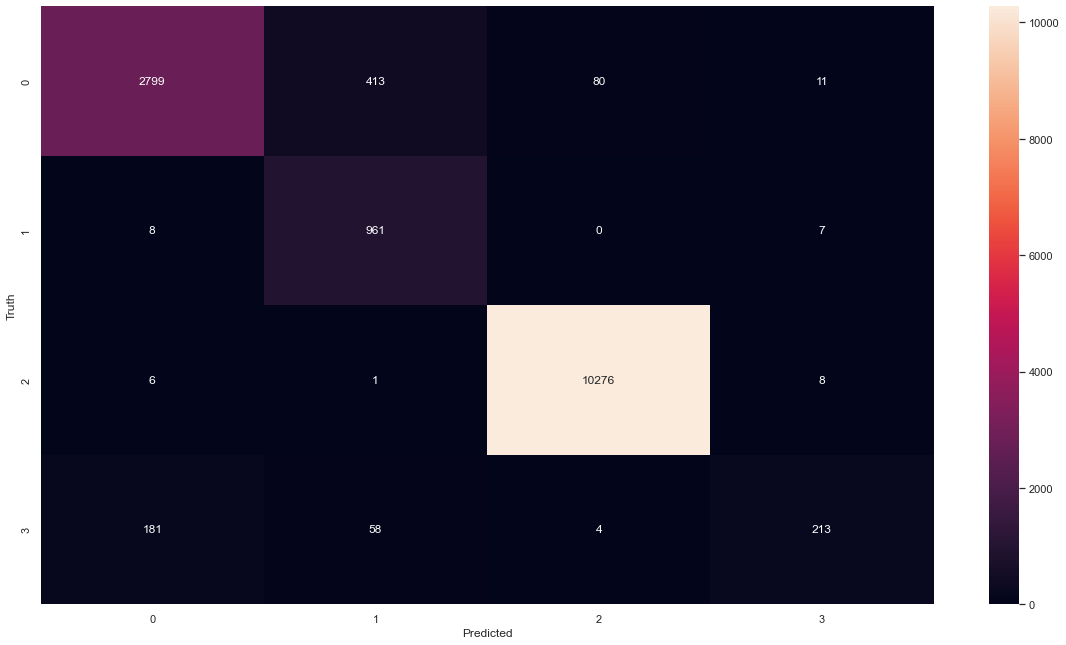

In [5]:
final_best_model = activity_recog.save_best_model('decision_tree','people_activity_recog_classification.pkl',\
                                                  x_train, y_train)
activity_recog.prediction_plot_report_generation(x_train, x_test, y_train, y_test, \
                                                 model_file_name='people_activity_recog_classification.pkl')
